In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import os
import seaborn as sns
import re
import datetime as dt

In [2]:
def make_data_19(dir, month):
    _dir = '_'+ str(dir)
    if month < 10:
        _month = '0'+str(month)
    else:
        _month = str(month)
    _file_ls = [i for i in os.listdir(_dir) if re.split('/|_',_dir)[-1]+_month in re.split('_', i)]
    freez2005 = pd.read_csv(os.path.join(_dir, [i for i in _file_ls if 'freezer' in i][0]))
    suth2005 = pd.read_csv(os.path.join(_dir, [i for i in _file_ls if 'suth' in i][0]))

    freez2005.columns = ['freezer_id', 'gw_time', 'status', 'fan_run', 'fan_trip',
        'freez_run', 'freez_trip', 'defrost', 'ctrl_mode', 'ctrl_operation',
        'operation', 'run_time', 'insert_dt']

    suth2005.columns = ['sensor_id', 'gw_time', 'status', 'color_list', 'avg_temperature',
        'avg_humidity', 'temperature', 'humidity', 'battery', 'available',
        'insert_dt']

    sensor_id = [329, 332, 335]
    freezer_id = [344, 362, 368]

    df_sensor = pd.DataFrame()
    df_freezer = pd.DataFrame()

    for elem in sensor_id:
        df_sensor = pd.concat([df_sensor, suth2005[suth2005['sensor_id'] == elem]])
        print("sensor id {}의 데이터 개수: {}".format(elem, len(suth2005[suth2005['sensor_id'] == elem])))
    for elem in freezer_id:
        df_freezer = pd.concat([df_freezer, freez2005[freez2005['freezer_id'] == elem]])
        print("freezer id {}의 데이터 개수: {}".format(elem, len(df_freezer[df_freezer['freezer_id'] == elem])))

    df_sensor.sort_values(by = ['sensor_id', 'gw_time'])
    df_freezer.sort_values(by = ['freezer_id', 'gw_time'])


    print('sensor: ',df_sensor['sensor_id'].unique())
    print('freezer: ', df_freezer['freezer_id'].unique())

    df_sensor = df_sensor.drop(columns = ['color_list','insert_dt'])
    df_freezer = df_freezer.drop(columns= ['insert_dt'])

    df_sensor['gw_time'] = pd.to_datetime(df_sensor['gw_time'])
    df_freezer['gw_time'] = pd.to_datetime(df_freezer['gw_time'])

    sensor_pos = {
        "329": {"x": 16, "y": 5},
        "332": {"x": 10, "y": 5},
        "335": {"x": 4, "y": 5},
        "338": {"x": 18, "y": 1}
    }
    freezer_pos = {
        "344": {"x": 16, "y": 0},
        "344-1": {"x": 14, "y": 0},
        "362": {"x": 11, "y": 0},
        "362-1": {"x": 8, "y": 0},
        "368": {"x": 4, "y": 0},
        "368-1": {"x": 2, "y": 0}
    }
    door_pos = {
        "door": {"x": 4, "y": 9}
    }

    sensor_pos = pd.DataFrame(sensor_pos).T
    sensor_pos['type'] = ['sensor']*len(sensor_pos)
    freezer_pos = pd.DataFrame(freezer_pos).T
    freezer_pos['type'] = ['freezer']*len(freezer_pos)
    door_pos = pd.DataFrame(door_pos).T
    door_pos['type']= ['door']*len(door_pos)
    sensor_pos = sensor_pos.reset_index()
    freezer_pos = freezer_pos.reset_index()
    door_pos = door_pos.reset_index()
    pos = pd.concat([sensor_pos,freezer_pos,door_pos])

    plt.figure(figsize = (12,10))
    sns.scatterplot(
        x = 'x', 
        y = 'y', 
        data = pos, 
        hue = 'index', 
        style='type',
        s = 70
        )
    # sensor
    for _id in sensor_id:
        x = sensor_pos[sensor_pos['index'] == str(_id)]['x']
        y = sensor_pos[sensor_pos['index'] == str(_id)]['y']
        plt.annotate(str(_id)+'(sensor)', xy = (x,y), xytext=(x, y-1), fontsize = 10, ha = 'center', arrowprops=dict(facecolor='black', width=1, shrink=0.1, headwidth=10)) 

    # # freezer
    for _id in freezer_id:
        x = freezer_pos[freezer_pos['index'] == str(_id)]['x']
        y = freezer_pos[freezer_pos['index'] == str(_id)]['y']
        plt.annotate(str(_id)+'(freezer)', xy = (x,y), xytext=(x, y-1), fontsize = 10, ha = 'center', arrowprops=dict(facecolor='black', width=1, shrink=0.1, headwidth=10)) 

    plt.annotate('door', xy=(pos[pos['type'] == 'door']['x'], pos[pos['type'] == 'door']['y']), xytext=(pos[pos['type'] == 'door']['x'],pos[pos['type'] == 'door']['y']-1),
                fontsize=10, ha='center',
                arrowprops=dict(facecolor='blue', width=1, shrink=0.1, headwidth=10))
            
    df0 = df_freezer.copy()['gw_time']
    for _id in df_freezer['freezer_id'].unique():
        df_tmp = df_freezer[df_freezer['freezer_id'] == _id]
        df_tmp.reset_index(drop = True)
        df_tmp.drop(columns= ['freezer_id'], inplace= True)
        df_tmp.columns = ['gw_time']+[x+'_'+str(_id) for x in df_freezer.columns if x not in ['freezer_id','gw_time']]
        df0 = pd.merge(df0, df_tmp, on = 'gw_time', how = 'outer')

    melted_freezer = df0

    df0 = df_sensor.copy()['gw_time']
    for _id in df_sensor['sensor_id'].unique():
        df_tmp = df_sensor[df_sensor['sensor_id'] == _id]
        df_tmp.reset_index(drop = True)
        df_tmp.drop(columns= ['sensor_id'], inplace= True)
        df_tmp.columns = ['gw_time']+[x+'_'+str(_id) for x in df_sensor.columns if x not in ['sensor_id','gw_time']]
        df0 = pd.merge(df0, df_tmp, on = 'gw_time', how = 'outer')

    melted_sensor = df0


    melted_df = pd.merge_asof(
        left=melted_sensor.sort_values(by="gw_time"),
        right=melted_freezer.sort_values(by="gw_time"),
        on="gw_time",
        direction="forward",
        tolerance=pd.Timedelta("30 second"),
        allow_exact_matches=False,
        suffixes=("_freezer", "_sensor"),
    )
    melted_df.drop_duplicates(inplace= True, ignore_index= True)
    melted_df.index = melted_df['gw_time']

    null_indexs  = melted_df[melted_df['freez_run_344'].isnull()].index
    null_columns = melted_df[melted_df['freez_run_344'].isnull()].columns

    for col in null_columns[1:]:
        melted_df[col] = melted_df[col].interpolate(method='time')

    for _id in sensor_id:
        melted_df['dT_'+str(_id)] =  melted_df['temperature_'+str(_id)] - melted_df['temperature_'+str(_id)].shift(1).fillna(melted_df['temperature_'+str(_id)][0])
    
    for elem in sensor_id:
        melted_df['temperature_'+str(elem)+'_prime'] = melted_df['temperature_'+str(elem)].shift(1)
        melted_df['dT_'+str(elem)+'_prime'] = melted_df['dT_'+str(elem)].shift(1)
    
    melted_df.dropna()

    melted_df.to_csv('df'+str(_dir)+_month+'.csv')
    
    return melted_df

sensor id 329의 데이터 개수: 88768
sensor id 332의 데이터 개수: 88768
sensor id 335의 데이터 개수: 88768
freezer id 344의 데이터 개수: 91063
freezer id 362의 데이터 개수: 91063
freezer id 368의 데이터 개수: 91063
sensor:  [329 332 335]
freezer:  [344 362 368]


C:\Users\Intellicode\AppData\Local\Temp\ipykernel_12184\3909709204.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp.drop(columns= ['freezer_id'], inplace= True)
C:\Users\Intellicode\AppData\Local\Temp\ipykernel_12184\3909709204.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp.drop(columns= ['freezer_id'], inplace= True)
C:\Users\Intellicode\AppData\Local\Temp\ipykernel_12184\3909709204.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

,gw_time,status_329,avg_temperature_329,avg_humidity_329,temperature_329,humidity_329,battery_329,available_329,status_332,avg_temperature_332,...,run_time_368,dT_329,dT_332,dT_335,temperature_329_prime,dT_329_prime,temperature_332_prime,dT_332_prime,temperature_335_prime,dT_335_prime
gw_time,,,,,,,,,,,,,,,,,,,,,
2020-05-01 00:00:10,2020-05-01 00:00:10,1,-20.84,68.48,-21.56,71.48,100,1,1,-20.84,...,0.0,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-01 00:00:41,2020-05-01 00:00:41,1,-20.85,68.63,-21.58,71.19,100,1,1,-20.85,...,1.0,-0.02,-0.01,0.00,-21.56,0.00,-20.59,0.00,-20.38,0.00
2020-05-01 00:01:11,2020-05-01 00:01:11,1,-20.86,68.68,-21.59,70.91,100,1,1,-20.86,...,1.0,-0.01,-0.01,0.01,-21.58,-0.02,-20.60,-0.01,-20.38,0.00
2020-05-01 00:01:41,2020-05-01 00:01:41,1,-20.88,68.66,-21.62,70.64,100,1,1,-20.88,...,2.0,-0.03,-0.02,0.00,-21.59,-0.01,-20.61,-0.01,-20.37,0.01
2020-05-01 00:02:11,2020-05-01 00:02:11,1,-20.89,68.60,-21.63,70.43,100,1,1,-20.89,...,2.0,-0.01,-0.01,-0.01,-21.62,-0.03,-20.63,-0.02,-20.37,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-31 23:57:51,2020-05-31 23:57:51,1,-20.86,68.83,-21.74,73.18,100,1,1,-20.86,...,590.0,-0.02,0.00,0.01,-21.72,-0.02,-20.52,-0.03,-20.34,0.00
2020-05-31 23:58:21,2020-05-31 23:58:21,1,-20.87,69.11,-21.74,72.89,100,1,1,-20.87,...,590.0,0.00,-0.02,-0.01,-21.74,-0.02,-20.52,0.00,-20.33,0.01
2020-05-31 23:58:52,2020-05-31 23:58:52,1,-20.88,69.22,-21.77,72.57,100,1,1,-20.88,...,591.0,-0.03,0.00,0.00,-21.74,0.00,-20.54,-0.02,-20.34,-0.01


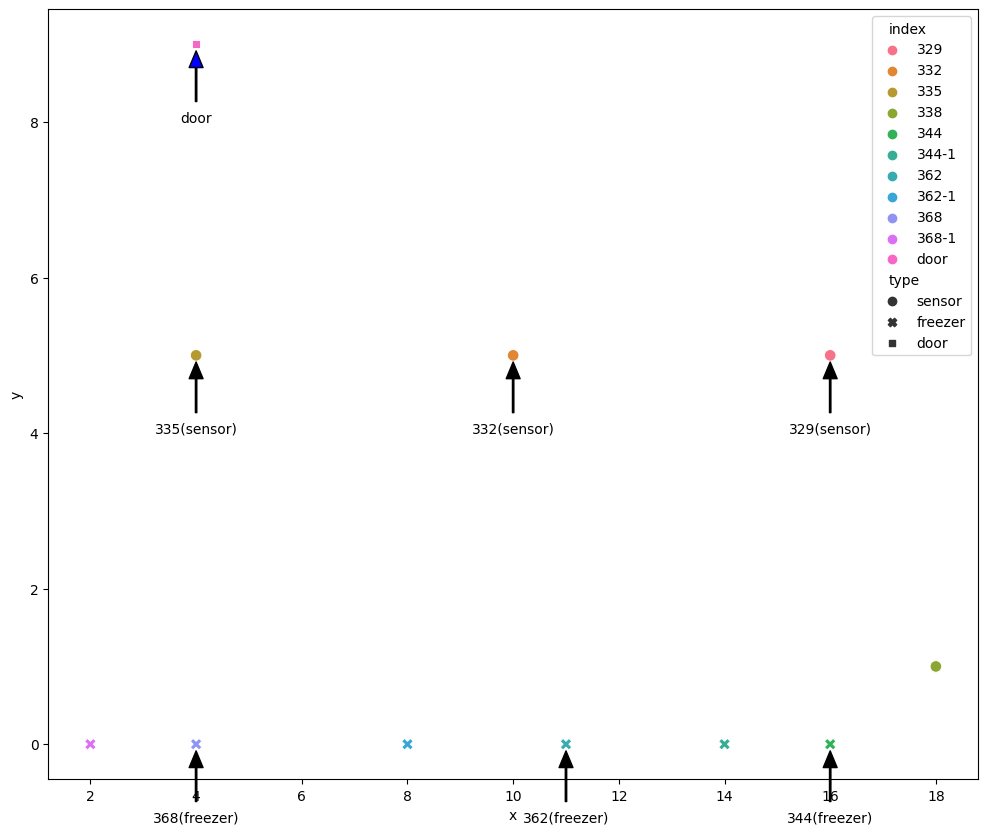

In [4]:
make_data_19(20,5)

In [11]:
def make_data_19_5min(dir, month):
    _dir = '_'+ str(dir)
    if month < 10:
        _month = '0'+str(month)
    else:
        _month = str(month)
    _file_ls = [i for i in os.listdir(_dir) if re.split('/|_',_dir)[-1]+_month in re.split('_', i)]
    freez2005 = pd.read_csv(os.path.join(_dir, [i for i in _file_ls if 'freezer' in i][0]))
    suth2005 = pd.read_csv(os.path.join(_dir, [i for i in _file_ls if 'suth' in i][0]))

    freez2005.columns = ['freezer_id', 'gw_time', 'status', 'fan_run', 'fan_trip',
        'freez_run', 'freez_trip', 'defrost', 'ctrl_mode', 'ctrl_operation',
        'operation', 'run_time', 'insert_dt']

    suth2005.columns = ['sensor_id', 'gw_time', 'status', 'color_list', 'avg_temperature',
        'avg_humidity', 'temperature', 'humidity', 'battery', 'available',
        'insert_dt']

    sensor_id = [329, 332, 335]
    freezer_id = [344, 362, 368]

    df_sensor = pd.DataFrame()
    df_freezer = pd.DataFrame()

    for elem in sensor_id:
        df_sensor = pd.concat([df_sensor, suth2005[suth2005['sensor_id'] == elem]])
        print("sensor id {}의 데이터 개수: {}".format(elem, len(suth2005[suth2005['sensor_id'] == elem])))
    for elem in freezer_id:
        df_freezer = pd.concat([df_freezer, freez2005[freez2005['freezer_id'] == elem]])
        print("freezer id {}의 데이터 개수: {}".format(elem, len(df_freezer[df_freezer['freezer_id'] == elem])))

    df_sensor.sort_values(by = ['sensor_id', 'gw_time'])
    df_freezer.sort_values(by = ['freezer_id', 'gw_time'])

    print('sensor: ',df_sensor['sensor_id'].unique())
    print('freezer: ', df_freezer['freezer_id'].unique())

    df_sensor = df_sensor.drop(columns = ['color_list','insert_dt'])
    df_freezer = df_freezer.drop(columns= ['insert_dt'])

    df_sensor['gw_time'] = pd.to_datetime(df_sensor['gw_time'])
    df_freezer['gw_time'] = pd.to_datetime(df_freezer['gw_time'])
    df_freezer['gw_time'] = df_freezer['gw_time'] + dt.timedelta(minutes = 5)
    sensor_pos = {
        "329": {"x": 16, "y": 5},
        "332": {"x": 10, "y": 5},
        "335": {"x": 4, "y": 5},
        "338": {"x": 18, "y": 1}
    }
    freezer_pos = {
        "344": {"x": 16, "y": 0},
        "344-1": {"x": 14, "y": 0},
        "362": {"x": 11, "y": 0},
        "362-1": {"x": 8, "y": 0},
        "368": {"x": 4, "y": 0},
        "368-1": {"x": 2, "y": 0}
    }
    door_pos = {
        "door": {"x": 4, "y": 9}
    }

    sensor_pos = pd.DataFrame(sensor_pos).T
    sensor_pos['type'] = ['sensor']*len(sensor_pos)
    freezer_pos = pd.DataFrame(freezer_pos).T
    freezer_pos['type'] = ['freezer']*len(freezer_pos)
    door_pos = pd.DataFrame(door_pos).T
    door_pos['type']= ['door']*len(door_pos)
    sensor_pos = sensor_pos.reset_index()
    freezer_pos = freezer_pos.reset_index()
    door_pos = door_pos.reset_index()
    pos = pd.concat([sensor_pos,freezer_pos,door_pos])

    plt.figure(figsize = (12,10))
    sns.scatterplot(
        x = 'x', 
        y = 'y', 
        data = pos, 
        hue = 'index', 
        style='type',
        s = 70
        )
    # sensor
    for _id in sensor_id:
        x = sensor_pos[sensor_pos['index'] == str(_id)]['x']
        y = sensor_pos[sensor_pos['index'] == str(_id)]['y']
        plt.annotate(str(_id)+'(sensor)', xy = (x,y), xytext=(x, y-1), fontsize = 10, ha = 'center', arrowprops=dict(facecolor='black', width=1, shrink=0.1, headwidth=10)) 

    # # freezer
    for _id in freezer_id:
        x = freezer_pos[freezer_pos['index'] == str(_id)]['x']
        y = freezer_pos[freezer_pos['index'] == str(_id)]['y']
        plt.annotate(str(_id)+'(freezer)', xy = (x,y), xytext=(x, y-1), fontsize = 10, ha = 'center', arrowprops=dict(facecolor='black', width=1, shrink=0.1, headwidth=10)) 

    plt.annotate('door', xy=(pos[pos['type'] == 'door']['x'], pos[pos['type'] == 'door']['y']), xytext=(pos[pos['type'] == 'door']['x'],pos[pos['type'] == 'door']['y']-1),
                fontsize=10, ha='center',
                arrowprops=dict(facecolor='blue', width=1, shrink=0.1, headwidth=10))
            
    df0 = df_freezer.copy()['gw_time']
    for _id in df_freezer['freezer_id'].unique():
        df_tmp = df_freezer[df_freezer['freezer_id'] == _id]
        df_tmp.reset_index(drop = True)
        df_tmp.drop(columns= ['freezer_id'], inplace= True)
        df_tmp.columns = ['gw_time']+[x+'_'+str(_id) for x in df_freezer.columns if x not in ['freezer_id','gw_time']]
        df0 = pd.merge(df0, df_tmp, on = 'gw_time', how = 'outer')

    melted_freezer = df0

    df0 = df_sensor.copy()['gw_time']
    for _id in df_sensor['sensor_id'].unique():
        df_tmp = df_sensor[df_sensor['sensor_id'] == _id]
        df_tmp.reset_index(drop = True)
        df_tmp.drop(columns= ['sensor_id'], inplace= True)
        df_tmp.columns = ['gw_time']+[x+'_'+str(_id) for x in df_sensor.columns if x not in ['sensor_id','gw_time']]
        df0 = pd.merge(df0, df_tmp, on = 'gw_time', how = 'outer')

    melted_sensor = df0


    melted_df = pd.merge_asof(
        left=melted_sensor.sort_values(by="gw_time"),
        right=melted_freezer.sort_values(by="gw_time"),
        on="gw_time",
        direction="nearest",
        tolerance=pd.Timedelta("30 second"),
        allow_exact_matches=False,
        suffixes=("_freezer", "_sensor"),
    )
    melted_df.drop_duplicates(inplace= True, ignore_index= True)
    melted_df.index = melted_df['gw_time']

    null_indexs  = melted_df[melted_df['freez_run_344'].isnull()].index
    null_columns = melted_df[melted_df['freez_run_344'].isnull()].columns

    for col in null_columns[1:]:
        melted_df[col] = melted_df[col].interpolate(method='time')

    for _id in sensor_id:
        melted_df['dT_'+str(_id)] =  melted_df['temperature_'+str(_id)] - melted_df['temperature_'+str(_id)].shift(1).fillna(melted_df['temperature_'+str(_id)][0])
    
    for elem in sensor_id:
        melted_df['temperature_'+str(elem)+'_prime'] = melted_df['temperature_'+str(elem)].shift(1)
        melted_df['dT_'+str(elem)+'_prime'] = melted_df['dT_'+str(elem)].shift(1)
    
    melted_df.dropna()

    melted_df.to_csv('df5'+str(_dir)+_month+'.csv')
    
    return melted_df

sensor id 329의 데이터 개수: 80129
sensor id 332의 데이터 개수: 80129
sensor id 335의 데이터 개수: 80129
freezer id 344의 데이터 개수: 82991
freezer id 362의 데이터 개수: 82991
freezer id 368의 데이터 개수: 82991
sensor:  [329 332 335]
freezer:  [344 362 368]


C:\Users\Intellicode\AppData\Local\Temp\ipykernel_1440\1852392397.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp.drop(columns= ['freezer_id'], inplace= True)
C:\Users\Intellicode\AppData\Local\Temp\ipykernel_1440\1852392397.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp.drop(columns= ['freezer_id'], inplace= True)
C:\Users\Intellicode\AppData\Local\Temp\ipykernel_1440\1852392397.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returnin

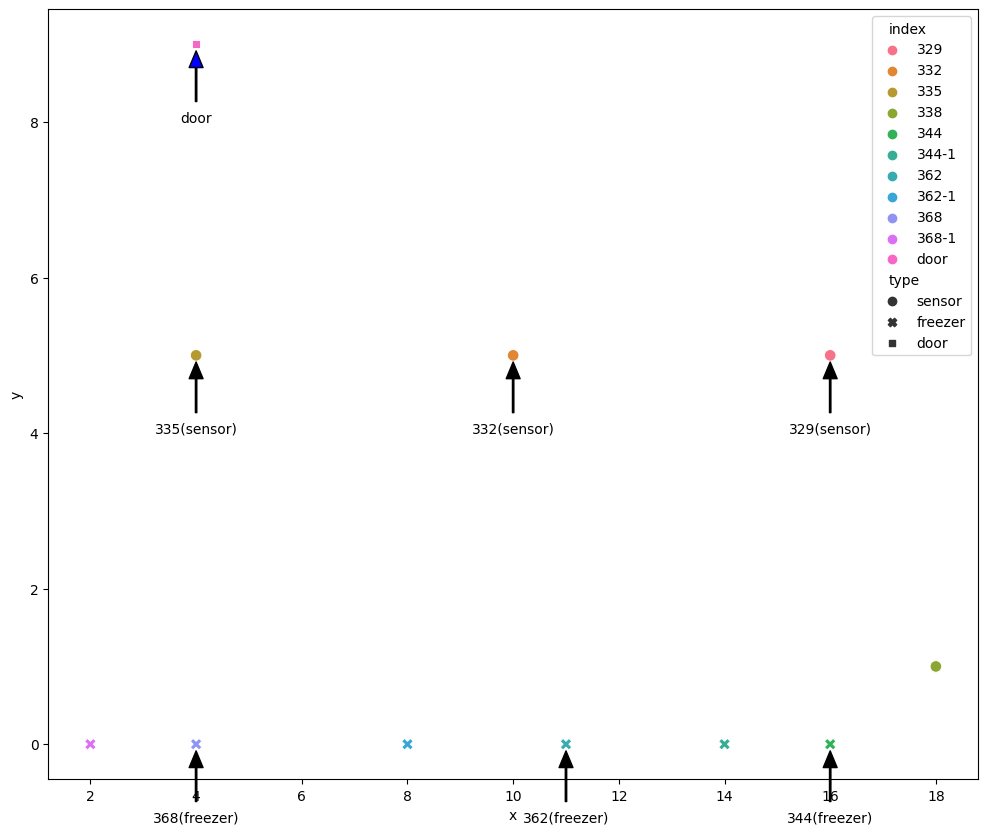

In [12]:
df5 = make_data_19_5min(21,2)